In [1]:
import torch
import cv2
import numpy as np
from PIL import ImageFont, ImageDraw, Image

from matplotlib import pyplot as plt
from matplotlib import cm as colormap
from matplotlib.colors import Normalize

from utils import objectness_filter_and_nms, get_center_coords, get_corner_coords

# TODO: test for different devices
def predict_and_save(img_path, save_path, model, device, labels_path='./data/coco.names', show=False):
    '''
    Predicts objects on an image, draws the bounding boxes around the predicted objects,
    and saves the image.
    
    Arguments
    ---------
    image_path: str
        The path to an image with objects to predict.
    save_path: str
        The path for the output image with detected objects.
    model: Darknet
        The model which will be used for inference.
    device: torch.device or str
        Device for calculations.
    labels_path: str
        The path to the object names.
    show: bool
        Whether to show the output image with bounding boxes, for example, in jupyter notebook
        
    Outputs
    -------
    prediction: torch.FloatTensor or NoneType
        Predictions of a size (<number of detected objects>, 4+1+<number of classes>). 
        prediction is NoneType when no object has been detected on an image.
    
    img_raw: numpy.ndarray
        A resulting image with bounding objects drawn on it.
    '''
    # make sure the arguments are of correct types
    assert isinstance(img_path, str), '"img_path" should be str'
    assert save_path is None or isinstance(save_path, str), 'save_path should be NoneType or str'
    assert isinstance(labels_path, str), '"labels_path" should be str'
#     assert isinstance(model, darknet.Darknet), 'model should be a Darknet module'
    assert isinstance(device, (torch.device, str)), 'device should be either torch.device or str'
    assert isinstance(show, bool), 'show should be boolean'

    # parameters of the vizualization: color palette, figsize to show, 
    # label parameters, jpeg quality
    norm = Normalize(vmin=0, vmax=model.classes)
    color_map = colormap.tab10
    figsize = (15, 15)
    line_thickness = 1
    font_face = cv2.FONT_HERSHEY_PLAIN
    font_scale = 1.1
    font_color = [255, 255, 255] # white
    font_thickness = 1
    jpg_quality = 80
    obj_thresh = 0.8 # 0.8
    nms_thresh = 0.4 # 0.4

    # make a dict: {class_number: class_name} if we have more than 1 class
    if model.classes > 1:
        # replacing with whitespace because we would like to remove space from
        # the text format later in naming the bounding boxes: 
        names = [name.replace('\n', ' ') for name in open(labels_path, 'r').readlines()]
        num2name = {num: name for num, name in enumerate(names)}
    
    else:
        # we don't need a class names if the the number of classes is 1
        num2name = {0: ''}

    # read an image and transform the colors from BGR to RGB
    img_raw = cv2.imread(img_path)
    img_raw = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)

    # add letterbox padding and save the pad sizes and scalling coefficient
    # to use it latter when drawing bboxes on the original image
    H, W, C = img_raw.shape
    H_new, W_new, scale = scale_numbers(H, W, model.model_width)
    img = cv2.resize(img_raw, (W_new, H_new))
    img, pad_sizes = letterbox_pad(img)

    # HWC -> CHW, scale intensities to [0, 1], send to pytorch, add 'batch-'dimension
    img = img.transpose((2, 0, 1))
    img = img / 255
    img = torch.from_numpy(img).float()
    img = img.unsqueeze(0)
    img = img.to(device)

    # make prediction
    prediction, loss = model(img, device=device)
    # and apply objectness filtering and nms. If returns None, draw a box that states it
    prediction = objectness_filter_and_nms(prediction, model.classes, obj_thresh, nms_thresh) # todo check whether it has batch dim
    print(f'obj_thresh: {obj_thresh}, nms_thresh: {nms_thresh}')
    
    # if show initialize a figure environment
    if show:
        plt.figure(figsize=figsize)
    
    ### if no objects have been detected draw one rectangle on the perimeter of the 
    # img_raw with text that no objects are found. for comments for this if condition 
    # please see the for-loop below
    if prediction is None:
        font_scale = 2
        font_thickness = 2
        top_left_coords = (0, 0)
        bbox_color = (0, 0, 0)
        font_color = (255, 255, 255)
        text = 'No objects found :-('
        text_size = cv2.getTextSize(text, font_face, font_scale, font_thickness)[0]
        bottom_right_coords_ = top_left_coords[0] + text_size[0] + 12, top_left_coords[1] + text_size[1] + 12
        xy_position = (2, 5 + text_size[1])
        cv2.rectangle(img_raw, top_left_coords, bottom_right_coords_, bbox_color, cv2.FILLED)
        cv2.putText(img_raw, text, xy_position, font_face, font_scale, font_color, font_thickness)
        if show:
            plt.imshow(img_raw)
        img_raw = cv2.cvtColor(img_raw, cv2.COLOR_RGB2BGR)
        cv2.imwrite(save_path, img_raw, [cv2.IMWRITE_JPEG_QUALITY, jpg_quality])

        return None, img_raw
    ###

    # since the predictions are made for a resized and padded images, 
    # the bounding boxes have to be scaled and shifted back
    pad_top, pad_bottom, pad_left, pad_right = pad_sizes
    prediction[:, 0] = (prediction[:, 0] - pad_left) / scale
    prediction[:, 1] = (prediction[:, 1] - pad_top) / scale
    prediction[:, 2] = prediction[:, 2] / scale
    prediction[:, 3] = prediction[:, 3] / scale

    # the, transform the coordinates (cx, cy, w, h) into corner coordinates: 
    # (top_left_x, top_left_y, bottom_right_x, bottom_right_y)
    top_left_x, top_left_y, bottom_right_x, bottom_right_y = get_corner_coords(prediction)

    # detach values from the computation graph, take the int part and transform to np.ndarray
    top_left_x = top_left_x.cpu().detach().int().numpy()
    top_left_y = top_left_y.cpu().detach().int().numpy()
    bottom_right_x = bottom_right_x.cpu().detach().int().numpy()
    bottom_right_y = bottom_right_y.cpu().detach().int().numpy()

    # add each prediction on the image and captures it with a class number
    for i in range(len(prediction)):

        ## ADD BBOXES
        # first we need to extract coords for both top left and bottom right corners
        # note: sometimes, the corner coordinates lie outside of the image itself
        # hence we need to keep them on image -> min and max
        top_left_coords = max(0, top_left_x[i]), max(0, top_left_y[i])
        bottom_right_coords = min(W, bottom_right_x[i]), min(H, bottom_right_y[i])
        # predicted class number
        class_score, class_int = torch.max(prediction[i, 5:5+model.classes], dim=-1) # todo dim (also see NMS with batch dim)
        class_score, class_int = float(class_score), int(class_int)
        
        # select the color for a class according to its label number and scale it to [0, 255]
        bbox_color = color_map(class_int)[:3]
        bbox_color = list(map(lambda x: x * 255, bbox_color))
        # add a bbox
        cv2.rectangle(img_raw, top_left_coords, bottom_right_coords, bbox_color, line_thickness)
        ## ADD A LABLE FOR EACH BBOX INSIDE THE RECTANGLE WITH THE SAME COLOR AS THE BBOX ITSELF
        # predicted class name to put on a bbox
        class_name = num2name[class_int]
        # text to name a box: class name and the probability in percents
        text = f'{class_name}{(class_score * 100):.0f}%'
        # size for the text
        text_size = cv2.getTextSize(text, font_face, font_scale, font_thickness)[0]
        # top-left and bottom right coordinates for the small rectangle for the label
        # (max is used because we don't want to have a tag outside of the image)
        top_left_coords_ = top_left_coords[0], max(0, top_left_coords[1] - text_size[1] - 2)
        bottom_right_coords_ = top_left_coords[0] + text_size[0] + 2, top_left_coords[1]# + text_size[1] + 2
        # adds a small rectangle of the same color to be the background for the label
        cv2.rectangle(img_raw, top_left_coords_, bottom_right_coords_, bbox_color, cv2.FILLED)
        # position for the text (for min and max comments see calculation of corner coordinates)
        xy_position = max(0, top_left_x[i]) + 2, max(0, top_left_y[i]) - 2
        # adds the class label with confidence
        cv2.putText(img_raw, text, xy_position, font_face, font_scale, font_color, font_thickness)
        
        rectangle_size = (text_size[0], text_size[1])

    # if show, then, show and close the environment
    if show:
        plt.imshow(img_raw)

    # RGB -> BGR and save output image
    img_raw = cv2.cvtColor(img_raw, cv2.COLOR_RGB2BGR)
    cv2.imwrite(save_path, img_raw, [cv2.IMWRITE_JPEG_QUALITY, jpg_quality])
    
    return prediction, img_raw



we also can remove bias due to bn
self.noobj_coeff: 1, self.obj_coeff: 100
self.noobj_coeff: 1, self.obj_coeff: 100
self.noobj_coeff: 1, self.obj_coeff: 100
make_layers returns net_info as well. check whether it"s necessary
shortcut is using output[i-1] instead of x check whether works with x
changing predictions in the nms loop make sure that it is not used later
not adding +1 in nms
loss: w and h aren"t put through sqroot
obj_thresh: 0.8, nms_thresh: 0.4


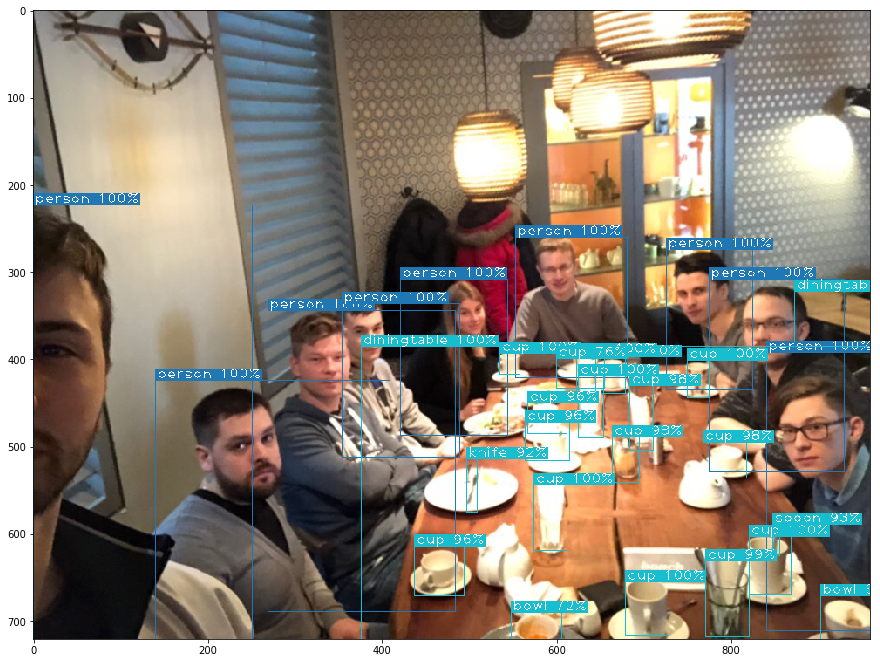

In [2]:
from matplotlib import pyplot as plt
import cv2
import torch

from darknet import Darknet
from utils import scale_numbers, letterbox_pad
%matplotlib inline

model = Darknet('./cfg/yolov3_608x608.cfg')
weight_file = './weights/yolov3.weights'
model.load_weights(weight_file)
model.eval();

device = torch.device('cpu')
labels_path='./data/coco.names'
# img_path = 'dog-cycle-car.png'
img_path = 'databreakfast_spb.jpg'
# img_path = 'NvFAv2v.png'
# img_path = 'typical_russian_morning.jpg'
save_path = './output.jpg'
show = True

img_raw = cv2.imread(img_path)
img_raw = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)

# add letterbox padding and save the pad sizes and scalling coefficient
# to use it latter when drawing bboxes on the original image
H, W, C = img_raw.shape
H_new, W_new, scale = scale_numbers(H, W, model.model_width)
img = cv2.resize(img_raw, (W_new, H_new))
img, pad_sizes = letterbox_pad(img)

# HWC -> CHW, scale intensities to [0, 1], send to pytorch, add 'batch-'dimension
img = img.transpose((2, 0, 1))
img = img / 255
img = torch.from_numpy(img).float()
img = img.unsqueeze(0)

prediction = model(img, device=device)
# (76 x 76 + 38 x 38 + 19 x 19) * 3 = 22743
prediction = predict_and_save(img_path, save_path, model, device, labels_path, show)

In [19]:
from PIL import Image, ImageFont, ImageDraw, ImageEnhance

source_img = Image.open("databreakfast_spb.jpg")

top_left = 10, 10

font = ImageFont.truetype("/usr/share/fonts/truetype/freefont/FreeSansBold.ttf", 29)

text = f"Face 100 %"

# get text size
text_size = font.getsize(text)

# set button size + 10px margins
rectangle_size = (text_size[0], text_size[1])

# create image with correct size and black background
button_img = Image.new('RGB', rectangle_size, "black")

# put text on button with 10px margins
button_draw = ImageDraw.Draw(button_img)
button_draw.text((0, 0), text, font=font)

# put button on source image in position (0, 0)
source_img.paste(button_img, top_left)

# save in new file
source_img.save("output.jpg", "JPEG")